# CTM MILP Model Running Environment (Varying Parameters)

**NOTE:** When about to make a new run, please **duplicate** this notebook then add necessary graphs and things below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *

# Add more CTM models here as needed
from ctmmodels.ringbarrier import DTSimplexRingBarrier as NewModel
from ctmmodels.parentmodel import ParentModel as OldModel

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* Default parameters used before:

{

    time_range = 30
    time_ticks = np.arange(0, time_range+1, 1)

    parameters = {
        'r_left': 1.0/3.0,
        'r_through': 1.0/3.0,
        'r_right': 1.0/3.0,
        'sat_flow_rate': 1800,
        'time_range': time_range,
        'time_step': 2,
        'g_min': 6,
        'g_max': 20
    }

}

* Saturation flow rate was set to 1800 vphpl, as this was the closest realistic value that matched the calculations from the parent paper.

* Traffic will be distributed evenly between the 4 lanes (left, through 1, through 2, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 0.5
}

# Varying parameters: demand, alpha, beta, gamma

In [4]:
def run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True):
    if new_model:
        model = NewModel(
            demand=demand,
            alpha=weights[0],
            beta=weights[1],
            gamma=weights[2],
            **parameters
        )
    else:
        model = OldModel(
            demand=demand,
            **parameters
        )

    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [5]:
_approach = SOUTHBOUND

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [6]:
def plot_volume(dfx, cell_path=_cell_path, title="Volume (Instantaneous and Cumulative)", headless=False, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [7]:
def plot_flow(dfy, cell_path=_cell_path, title="Flow (Instantaneous and Cumulative)", headless=False, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [8]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title="Greentime graphs", headless=False, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

In [9]:
def plot_greentime_nophase(dfg):
    df_g_map = dfg.pivot(index='timestep', columns='cell', values='is_green')
    approaches = [ [ (CELL_MOVEMENT,t,a) for t in range(3) ] for a in range(4) ]

    _, axs = plt.subplots(4,3,figsize=(20,20), sharey=True)

    for i in range(4):
        for j in range(3):
             sns.lineplot(data=df_g_map[[approaches[i][j]]], ax=axs[i][j])

## Comparing greentime as a heatmap

In [44]:
def plot_greentime_map(dfg, title="Greentime maps", headless=False, filename='greentime.png', new_model=True):
    fig, axs = plt.subplots(figsize=(18,8))

    phase_map = {
        (0,0,0): [(2, LEFT_TURN, WESTBOUND), (2, RIGHT_TURN, NORTHBOUND)], # WBL, NBR
        (0,0,1): [(2, THROUGH_TURN, EASTBOUND), (2, RIGHT_TURN, EASTBOUND)],
        (0,1,0): [(2, LEFT_TURN, SOUTHBOUND), (2, RIGHT_TURN, WESTBOUND)],
        (0,1,1): [(2, THROUGH_TURN, SOUTHBOUND), (2, RIGHT_TURN, SOUTHBOUND)],
        (1,0,0): [(2, LEFT_TURN, EASTBOUND), (2, RIGHT_TURN, SOUTHBOUND)],
        (1,0,1): [(2, THROUGH_TURN, WESTBOUND), (2, RIGHT_TURN, WESTBOUND)],
        (1,1,0): [(2, LEFT_TURN, NORTHBOUND), (2, RIGHT_TURN, EASTBOUND)],
        (1,1,1): [(2, THROUGH_TURN, NORTHBOUND), (2, RIGHT_TURN, NORTHBOUND)],
    }
    
    dfg.is_green = pd.to_numeric(dfg.is_green, 'is_green', downcast='integer')
    
    if new_model:
        dfg_conv = pd.DataFrame(columns=['timestep', 'cell', 'is_green'])
        for row in dfg.itertuples():
            raw = row[1:]
            converteds = [(raw[0], c, raw[2]) for c in phase_map[raw[1]]]
            for entry in converteds:
                dfg_conv.loc[-1] = entry
                dfg_conv.index += 1
        dfg_matrix = dfg_conv.pivot_table(index='cell', columns='timestep', values='is_green', aggfunc=np.sum)
        dfg_matrix = dfg_matrix.replace(2,1)
    else:
        dfg_matrix = dfg.pivot(index='cell', columns='timestep', values='is_green')

    dfg_matrix = dfg_matrix.reindex(index=[
        (2,LEFT_TURN,EASTBOUND), (2,RIGHT_TURN,EASTBOUND), (2,THROUGH_TURN,EASTBOUND),
        (2,LEFT_TURN,NORTHBOUND), (2,RIGHT_TURN,NORTHBOUND), (2,THROUGH_TURN,NORTHBOUND),
        (2,LEFT_TURN,SOUTHBOUND), (2,RIGHT_TURN,SOUTHBOUND), (2,THROUGH_TURN,SOUTHBOUND),
        (2,LEFT_TURN,WESTBOUND), (2,RIGHT_TURN,WESTBOUND), (2,THROUGH_TURN,WESTBOUND),
    ])
    sns.heatmap(data=dfg_matrix)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [11]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                        filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                            .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                      filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                          .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                           .format(demand, alpha*100, capacity, max_flow, flow_weight),
                       filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                           .format(demand, alpha, flow_weight))

In [12]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [13]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## 1. Testing effect of flow rate reduction on Old and New models

### New Model, FRR = 1

In [45]:
parameters['flow_rate_reduction'] = 1
demand = 600

dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 4522 rows and 352 columns.
MIP Presolve modified 1114 coefficients.
Aggregator did 157 substitutions.
Reduced MIP has 5436 rows, 3001 columns, and 20390 nonzeros.
Reduced MIP has 405 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (22.70 ticks)
Found incumbent of value 1356.223176 after 0.05 sec. (41.34 ticks)
Probing fixed 0 vars, tightened 164 bounds.
Probing time = 0.00 sec. (0.99 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 964 rows and 164 columns.
Aggregator did 148 substitutions.
Reduced MIP has 4324 rows, 2689 columns, and 17990 nonzeros.
Reduced MIP has 405 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (10.56 ticks)
Probing time = 0.00 sec. (0.75 ticks)
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 4324 rows, 2689 columns, and 17990 nonzeros.
Reduced MIP has 405 binarie

  10762  1900      280.5325    22      280.5629      264.5738  2417170    5.70%
  10980  1943      274.7828   110      280.5629      264.5738  2460474    5.70%
  11231  1969      268.4093   173      280.5629      264.5738  2501963    5.70%
  11488  1995        cutoff            280.5629      264.5738  2548275    5.70%
Elapsed time = 88.49 sec. (55638.87 ticks, tree = 26.78 MB, solutions = 9)
  11677  2014      271.8611   168      280.5629      264.5738  2583532    5.70%
  11871  2026      280.3856    65      280.5629      264.9516  2637244    5.56%
  12128  2038        cutoff            280.5629      265.3414  2658740    5.43%
  12405  2056      274.8430   124      280.5629      265.7173  2677850    5.29%
  12623  2060        cutoff            280.5629      266.0873  2757791    5.16%
  12856  2064      274.7937   153      280.5629      266.6734  2797097    4.95%
  13105  2053        cutoff            280.5629      267.2587  2836528    4.74%
  13368  2036        cutoff            280.56

In [46]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 129.684605837

Delay: 3175.37552743

Throughput: 66.835443038

Objective Value: 280.562878349


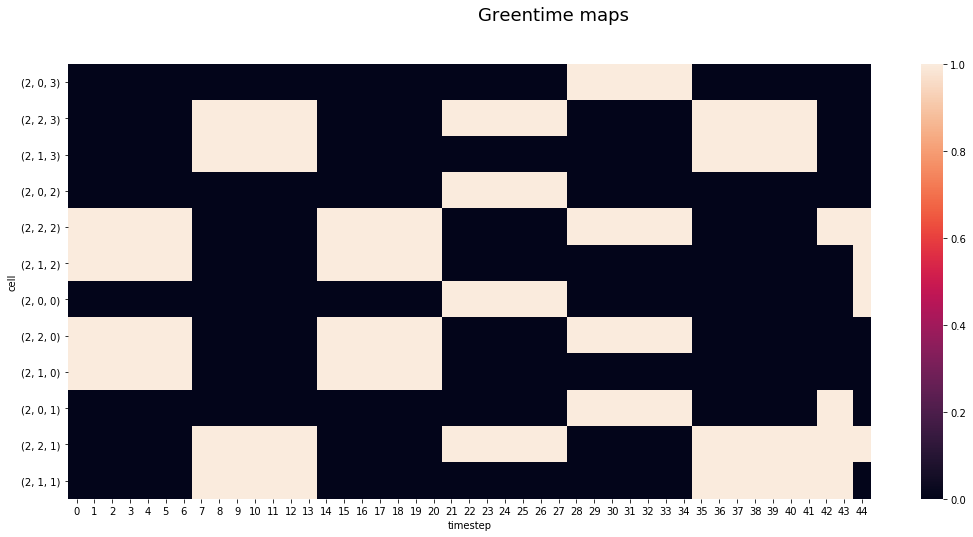

In [47]:
plot_greentime_map(dfg)

### New Model, FRR = 0.5

In [17]:
parameters['flow_rate_reduction'] = 0.5
demand = 600

dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 3172 rows and 292 columns.
MIP Presolve modified 756 coefficients.
Aggregator did 142 substitutions.
Reduced MIP has 3488 rows, 1906 columns, and 11888 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.49 ticks)
Found incumbent of value 913.976488 after 0.04 sec. (24.26 ticks)
Probing fixed 0 vars, tightened 129 bounds.
Probing time = 0.00 sec. (0.62 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2796 rows, 1714 columns, and 10180 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.48 ticks)
Probing time = 0.00 sec. (0.43 ticks)
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 2796 rows, 1714 columns, and 10180 nonzeros.
Reduced MIP has 270 binaries, 0

  58105 13750        cutoff           -173.6983     -180.8333  2302901    4.11%
  59477 13551     -174.8270    76     -173.6983     -180.5493  2353804    3.94%
  60909 13322        cutoff           -173.6983     -180.2689  2400257    3.78%
  62289 13123        cutoff           -173.6983     -179.9144  2430219    3.58%
  63685 12844        cutoff           -173.6983     -179.6062  2473283    3.40%
  65113 12546        cutoff           -173.6983     -179.3003  2511157    3.23%
  66458 11919        cutoff           -173.6983     -178.9590  2578737    3.03%
  67973 11542        cutoff           -173.6983     -178.5794  2605083    2.81%
  69576 10746     -175.1345    86     -173.6983     -178.1860  2665693    2.58%
  71072 10169        cutoff           -173.6983     -177.8274  2702130    2.38%
Elapsed time = 106.04 sec. (63328.26 ticks, tree = 131.18 MB, solutions = 13)
  72758  9297        cutoff           -173.6983     -177.4324  2751627    2.15%
  74572  8317     -174.8677    92     -173

In [18]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 117.891776085

Delay: 1102.37974684

Throughput: 60.2784810127

Objective Value: -173.698272887


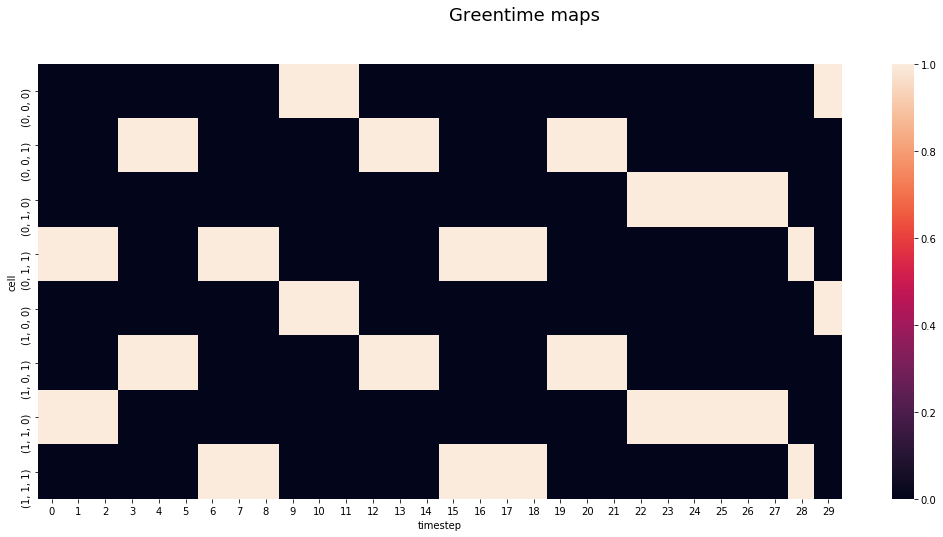

In [19]:
plot_greentime_map(dfg)

### Old Model, FRR = 1

In [20]:
parameters['flow_rate_reduction'] = 1
demand = 600

dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, new_model=False, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 4208 rows and 580 columns.
MIP Presolve modified 568 coefficients.
Aggregator did 770 substitutions.
Reduced MIP has 2372 rows, 1470 columns, and 7308 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.70 ticks)
Probing time = 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1140 rows and 720 columns.
Reduced MIP has 1232 rows, 750 columns, and 3990 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.28 ticks)
Probing time = 0.00 sec. (0.09 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (25.77 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer 

In [21]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 0.185874938965

Delay: 1216.55696203

Throughput: 66.835443038

Objective Value: 66.835443038


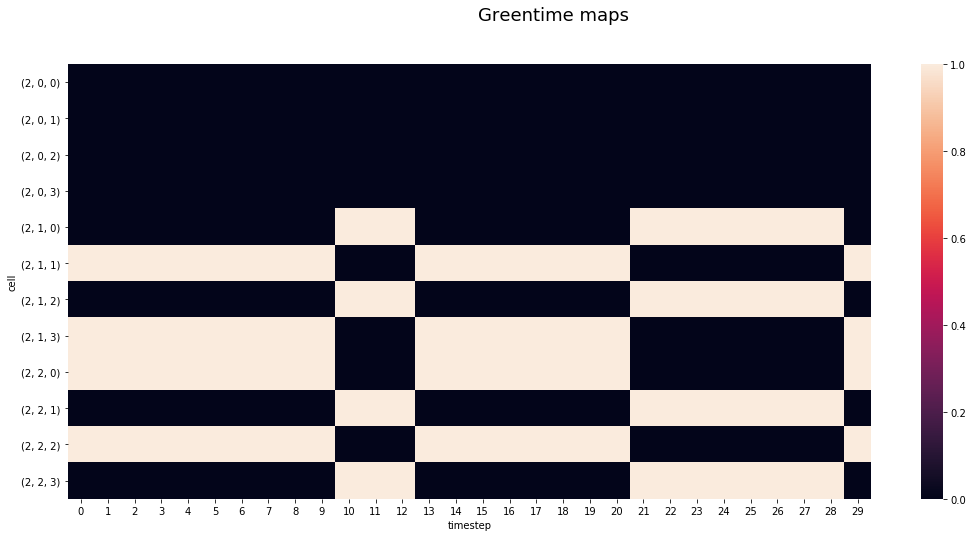

In [22]:
plot_greentime_map(dfg)

### Old Model, FRR = 0.5

In [21]:
parameters['flow_rate_reduction'] = 0.5
demand = 600

dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, new_model=False, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 4208 rows and 580 columns.
MIP Presolve modified 568 coefficients.
Aggregator did 770 substitutions.
Reduced MIP has 2372 rows, 1470 columns, and 7508 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (18.03 ticks)
Probing time = 0.00 sec. (0.15 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1140 rows and 720 columns.
Reduced MIP has 1232 rows, 750 columns, and 4090 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.36 ticks)
Probing time = 0.00 sec. (0.09 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (28.20 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer 

In [22]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 0.202221155167

Delay: 1200.97468354

Throughput: 66.835443038

Objective Value: 66.835443038


In [31]:
plot_greentime_map(dfg, new_model=False)

TypeError: plot_greentime_map() got an unexpected keyword argument 'new_model'

### Notes

* With the flow rate reduction set to 1, the flow rate at the first green timestep is reduced to 0. This allows the solver to force a greentime limit of at least 1, and avoid scenarios like the last 2 seconds of the case where the FRR = 0.5

## 2. Testing effect of time range on Old and New models

### New Model, Time range = 45 steps, 1.5 minutes

In [28]:
time_range = 45
time_ticks = np.arange(0, time_range+1, 1)
parameters['time_range'] = time_range
parameters['flow_rate_reduction'] = 1

dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 4522 rows and 352 columns.
MIP Presolve modified 1146 coefficients.
Aggregator did 157 substitutions.
Reduced MIP has 5588 rows, 3001 columns, and 18462 nonzeros.
Reduced MIP has 405 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (20.12 ticks)
Found incumbent of value 1356.223176 after 0.04 sec. (37.49 ticks)
Probing fixed 0 vars, tightened 164 bounds.
Probing time = 0.00 sec. (0.89 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 964 rows and 164 columns.
Aggregator did 148 substitutions.
Reduced MIP has 4476 rows, 2689 columns, and 16062 nonzeros.
Reduced MIP has 405 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.73 ticks)
Probing time = 0.00 sec. (0.65 ticks)
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 4476 rows, 2689 columns, and 16062 nonzeros.
Reduced MIP has 405 binaries

  28603 14357        cutoff            249.5341      233.1723  2209766    6.56%
* 28852 14793      integral     0      248.4860      233.2168  2247442    6.14%
  29452 14133      243.6436    96      248.4860      233.3812  2263782    6.08%
  29810 14361      244.3022    62      248.4860      233.4454  2303341    6.05%
  29996 14414      246.3067   170      248.4860      233.4678  2310910    6.04%
  30578 14563      247.8665   137      248.4860      233.7376  2333695    5.94%
  31271 14867        cutoff            248.4860      233.9141  2364793    5.86%
  31822 15105      245.2187   166      248.4860      233.9832  2390992    5.84%
  32409 15506      242.5894    95      248.4860      234.0978  2453546    5.79%
  33099 15676        cutoff            248.4860      234.2040  2473987    5.75%
Elapsed time = 108.70 sec. (63247.21 ticks, tree = 310.54 MB, solutions = 15)
  33892 15885      242.2310   135      248.4860      234.3956  2496824    5.67%
  34604 16121      248.1719   128      248

In [29]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 389.654031992

Delay: 3039.07172996

Throughput: 66.835443038

Objective Value: 247.074043367


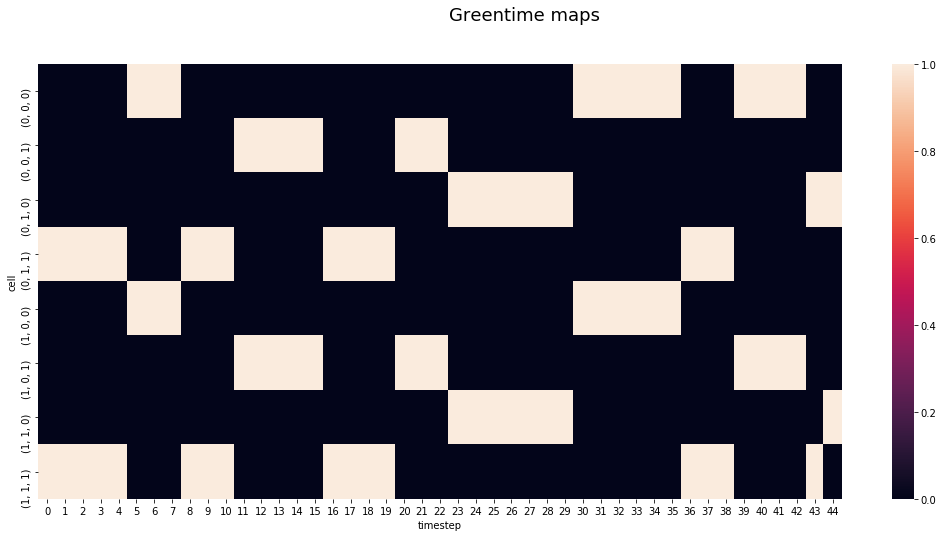

In [30]:
plot_greentime_map(dfg)

### Old Model, Time range = 45 steps, 1.5 minutes

In [33]:
time_range = 45
time_ticks = np.arange(0, time_range+1, 1)
parameters['time_range'] = time_range
parameters['flow_rate_reduction'] = 1

dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, new_model=False, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 6158 rows and 760 columns.
MIP Presolve modified 868 coefficients.
Aggregator did 1145 substitutions.
Reduced MIP has 3812 rows, 2325 columns, and 11688 nonzeros.
Reduced MIP has 45 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (28.03 ticks)
Probing time = 0.00 sec. (0.18 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1830 rows and 1140 columns.
Reduced MIP has 1982 rows, 1185 columns, and 6420 nonzeros.
Reduced MIP has 45 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (8.39 ticks)
Probing time = 0.00 sec. (0.14 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.07 sec. (59.18 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Inte

In [34]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 0.248247146606

Delay: 3826.32911392

Throughput: 66.835443038

Objective Value: 66.835443038


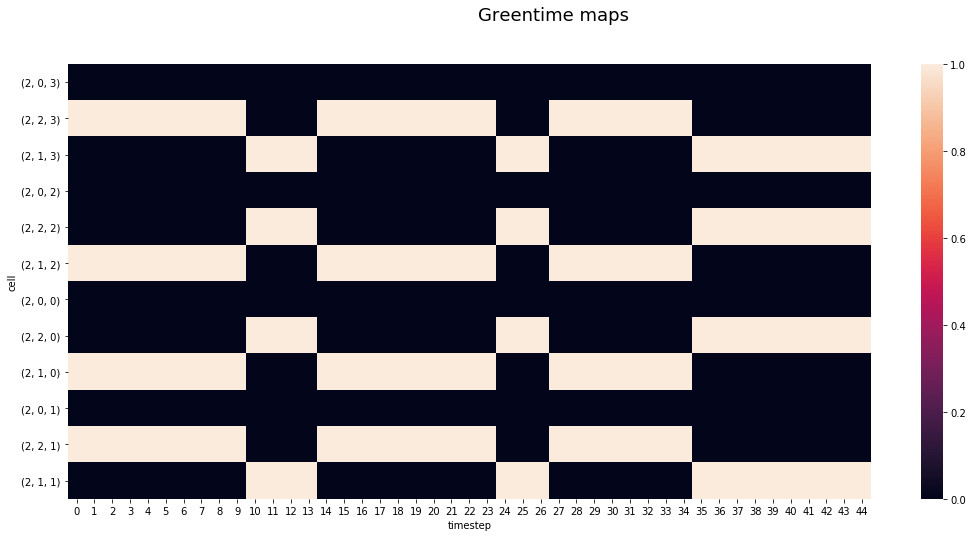

In [37]:
plot_greentime_map(dfg, new_model=False)

## 3. Testing effect of varying greentime limits on New and Old models

In [40]:
time_range = 45
time_ticks = np.arange(0, time_range+1, 1)
parameters['time_range'] = time_range
parameters['flow_rate_reduction'] = 1
demand = 600

### 15-50 seconds, New Model

In [39]:
parameters['g_min'] = 15
parameters['g_max'] = 50

In [41]:
dfx, dfy, dfg, _, obj_values, runtime = run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 4522 rows and 352 columns.
MIP Presolve modified 1114 coefficients.
Aggregator did 157 substitutions.
Reduced MIP has 5436 rows, 3001 columns, and 20390 nonzeros.
Reduced MIP has 405 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (22.70 ticks)
Found incumbent of value 1356.223176 after 0.05 sec. (41.34 ticks)
Probing fixed 0 vars, tightened 164 bounds.
Probing time = 0.01 sec. (0.99 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 964 rows and 164 columns.
Aggregator did 148 substitutions.
Reduced MIP has 4324 rows, 2689 columns, and 17990 nonzeros.
Reduced MIP has 405 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (10.56 ticks)
Probing time = 0.00 sec. (0.75 ticks)
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 4324 rows, 2689 columns, and 17990 nonzeros.
Reduced MIP has 405 binarie

  10762  1900      280.5325    22      280.5629      264.5738  2417170    5.70%
  10980  1943      274.7828   110      280.5629      264.5738  2460474    5.70%
  11231  1969      268.4093   173      280.5629      264.5738  2501963    5.70%
  11488  1995        cutoff            280.5629      264.5738  2548275    5.70%
Elapsed time = 93.75 sec. (55638.87 ticks, tree = 26.78 MB, solutions = 9)
  11677  2014      271.8611   168      280.5629      264.5738  2583532    5.70%
  11871  2026      280.3856    65      280.5629      264.9516  2637244    5.56%
  12128  2038        cutoff            280.5629      265.3414  2658740    5.43%
  12405  2056      274.8430   124      280.5629      265.7173  2677850    5.29%
  12623  2060        cutoff            280.5629      266.0873  2757791    5.16%
  12856  2064      274.7937   153      280.5629      266.6734  2797097    4.95%
  13105  2053        cutoff            280.5629      267.2587  2836528    4.74%
  13368  2036        cutoff            280.56

In [42]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 136.267417908

Delay: 3175.37552743

Throughput: 66.835443038

Objective Value: 280.562878349


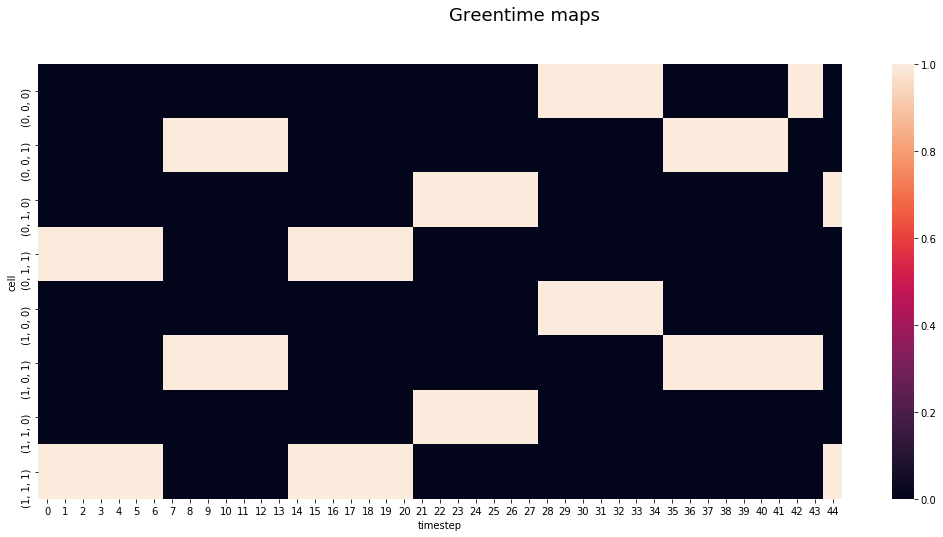

In [43]:
plot_greentime_map(dfg)